In [11]:
!pip install d2l==0.17.2

  Using cached matplotlib-3.3.3-cp37-cp37m-manylinux1_x86_64.whl (11.6 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.0.2
    Uninstalling matplotlib-3.0.2:
      Successfully uninstalled matplotlib-3.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [12]:
pip install matplotlib==3.0.2

  Using cached matplotlib-3.0.2-cp37-cp37m-manylinux1_x86_64.whl (12.9 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.3.3
    Uninstalling matplotlib-3.3.3:
      Successfully uninstalled matplotlib-3.3.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
plotnine 0.6.0 requires matplotlib>=3.1.1, but you have matplotlib 3.0.2 which is incompatible.
mizani 0.6.0 requires matplotlib>=3.1.1, but you have matplotlib 3.0.2 which is incompatible.
d2l 0.17.2 requires matplotlib==3.3.3, but you have matplotlib 3.0.2 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


The phenomenon of fitting our training data more closely than we fit the underlying distribution is called overfitting, and the techniques used to combat overfitting are called regularization.

##Polynomial Regression
Fitting polynomials to data

In [13]:
import math
import numpy as np
import tensorflow as tf
from d2l import tensorflow as d2l

###Generating the Dataset

We will synthesize 100 samples each for the training set and test set.

In [14]:
max_degree = 20  # Maximum degree of the polynomial
n_train, n_test = 100, 100  # Training and test dataset sizes
true_w = np.zeros(max_degree)  # Allocate lots of empty space
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # `gamma(n)` = (n-1)!
# Shape of `labels`: (`n_train` + `n_test`,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [15]:
# Convert from NumPy ndarrays to tensors
true_w, features, poly_features, labels = [tf.constant(x, dtype=
    tf.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
 array([[-1.0582741],
        [-0.9692405]], dtype=float32)>,
 <tf.Tensor: shape=(2, 20), dtype=float32, numpy=
 array([[ 1.0000000e+00, -1.0582741e+00,  5.5997211e-01, -1.9753467e-01,
          5.2261461e-02, -1.1061390e-02,  1.9509973e-03, -2.9495571e-04,
          3.9017999e-05, -4.5879715e-06,  4.8553318e-07, -4.6711563e-08,
          4.1194701e-09, -3.3534836e-10,  2.5349322e-11, -1.7884355e-12,
          1.1829094e-13, -7.3637792e-15,  4.3293874e-16, -2.4114098e-17],
        [ 1.0000000e+00, -9.6924049e-01,  4.6971360e-01, -1.5175514e-01,
          3.6771808e-02, -7.1281455e-03,  1.1514812e-03, -1.5943746e-04,
          1.9316656e-05, -2.0802763e-06,  2.0162879e-07, -1.7766073e-08,
          1.4349665e-09, -1.0698674e-10,  7.4068486e-12, -4.7860121e-13,
          2.8992481e-14, -1.6529815e-15,  8.9007592e-17, -4.5405139e-18]],
       dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.7465562, 1.3521672], dtype=

###Training and Testing the Model
Let us first implement a function to evaluate the loss on a given dataset.

In [16]:
def evaluate_loss(net, data_iter, loss):
    """Evaluate the loss of a model on the given dataset."""
    metric = d2l.Accumulator(2)  # Sum of losses, no. of examples
    for X, y in data_iter:
        l = loss(net(X), y)
        metric.add(tf.reduce_sum(l), d2l.size(l))
    return metric[0] / metric[1]

Define the training function.

In [17]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = tf.losses.MeanSquaredError()
    input_shape = train_features.shape[-1]
    # Switch off the bias since we already catered for it in the polynomial
    # features
    net = tf.keras.Sequential()
    net.add(tf.keras.layers.Dense(1, use_bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    test_iter = d2l.load_array((test_features, test_labels), batch_size,
                               is_train=False)
    trainer = tf.keras.optimizers.SGD(learning_rate=.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net.get_weights()[0].T)

###Third-Order Polynomial Function Fitting (Normal)

The results show that this model’s training and test losses can be both effectively reduced.

weight: [[ 4.9986596  1.2066557 -3.3972821  5.584861 ]]


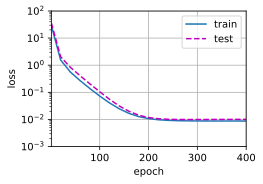

In [18]:
# Pick the first four dimensions, i.e., 1, x, x^2/2!, x^3/3! from the
# polynomial features
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

Output of cell [18]:

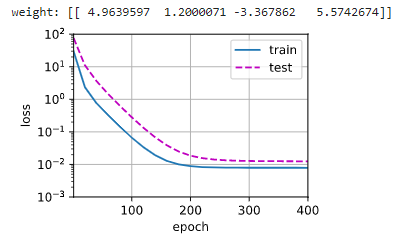

### Linear Function Fitting (Underfitting)

After the decline in early epochs, it becomes difficult to further decrease this model’s training loss. After the last epoch iteration has been completed, the training loss is still high. 

weight: [[3.6607819 4.5984325]]


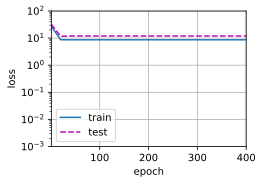

In [19]:
# Pick the first two dimensions, i.e., 1, x, from the polynomial features
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

Output of cell [19]:

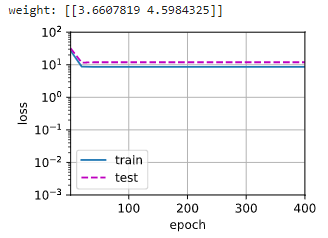

### Higher-Order Polynomial Function Fitting (Overfitting)
Now let us try to train the model using a polynomial of too high degree.

weight: [[ 5.0056324   1.3193289  -3.399386    4.9577994  -0.20559493  1.751293
   0.48879445 -0.23869944  0.23470452  0.4914334  -0.18577172 -0.16679199
  -0.11723592  0.3984931  -0.4681025  -0.22127835  0.39697343  0.20218867
   0.21354777  0.18906462]]


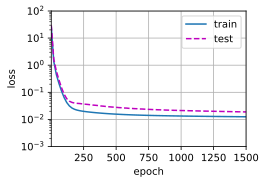

In [20]:
# Pick all the dimensions from the polynomial features
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)

Output of cell [20]:

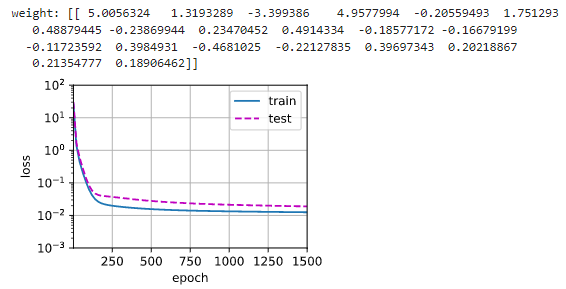

##Summary
Since the generalization error cannot be estimated based on the training error, simply minimizing the training error will not necessarily mean a reduction in the generalization error. Machine learning models need to be careful to safeguard against overfitting so as to minimize the generalization error.

A validation set can be used for model selection, provided that it is not used too liberally.

Underfitting means that a model is not able to reduce the training error. When training error is much lower than validation error, there is overfitting.

We should choose an appropriately complex model and avoid using insufficient training samples.